# Deep Learning - Mini Challenge 1
**Author**: Yvo Keller

**Semester**: FS23

## Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchmetrics

import lightning as li
from lightning.pytorch.callbacks import TQDMProgressBar, Callback
from lightning.pytorch.loggers import WandbLogger

import wandb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(f"Environment Info")

# Device
print(f" | Device: {os.uname().nodename}")

# GPU Env Info
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print(f" | MPS Device: {mps_device}")

# CPU Env Info
print(f" | CPU Threads: {torch.get_num_threads()}")

Environment Info
 | Device: macbook-pro-von-yvo-1.home
 | MPS Device: mps
 | CPU Threads: 12


In [3]:
# Initialize Weights & Biases
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'
wandb.login()

wandb: Currently logged in as: yvokeller (sensor-based-activity-recognition). Use `wandb login --relogin` to force relogin


True

# Schritt 1: Auswahl Task / Datensatz 

1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll.  
2. Diskutiere die Idee mit dem Fachcoach.  


**Absprache mit Fachcoach**:

- Deadline: 20. April 2023
- Task: Klassifizierung des CIFAR-10 Datensatzes (32x32 Bilder von 10 Klassen)
- Nutzung von W&B zur Model Evaluation
- [Deep Learning Vorlesungen](https://fleuret.org/dlc/) von Francois Fleuret als Grundlage


# Schritt 2: Daten Kennenlernen 
1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der Klassen. 
2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.

## Load & Preprocess Dataset 

In [4]:
transform = torchvision.transforms.Compose([
    # 1. transform to pytorch Tensor, which also scales the values to [0, 1]
    torchvision.transforms.ToTensor(), 
    # 2. normalize the tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels (RGB) of the image
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def get_dataloaders(batch_size, val_nobatch=False, shuffle=False):
    train_dataloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=batch_size, 
        num_workers=0,
        shuffle=shuffle, 
        pin_memory=False,
    )

    val_batch_size = batch_size if not val_nobatch else testset.__len__()
    print(f"DataLoader | Validation Batch Size: {val_batch_size}")
    val_dataloader = torch.utils.data.DataLoader(
        testset,
        batch_size=val_batch_size, 
        num_workers=0,
        shuffle=shuffle,
        pin_memory=False,
    )

    return train_dataloader, val_dataloader

## Explorative Data Analysis

### Color Channels
Visualizing the 3 color channels of an image, by eye we not see much of a difference between the image's color channels.

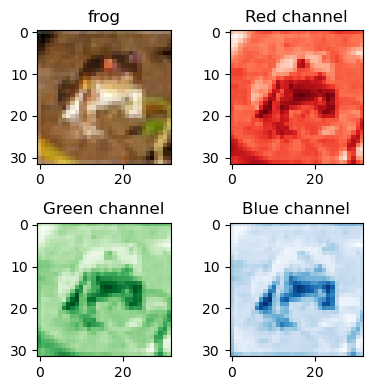

In [6]:
# Plot an image from the dataset
def plot_image(id, dataset):
    img = dataset.data[id]

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()

    axs[0].imshow(img)
    axs[0].set_title(dataset.classes[dataset.targets[id]])

    axs[1].imshow(img[:,:,0], cmap='Reds')
    axs[1].set_title('Red channel')

    axs[2].imshow(img[:,:,1], cmap='Greens')
    axs[2].set_title('Green channel')

    axs[3].imshow(img[:,:,2], cmap='Blues')
    axs[3].set_title('Blue channel')

    plt.tight_layout()
    plt.show()

plot_image(0, trainset)

### Looking at some CIFAR-10 images
Here, we can see a few examples of the images in the CIFAR-10 dataset that I am going to train models on. They are all 32x32 pixels, and are color images with 3 color channels (RGB).

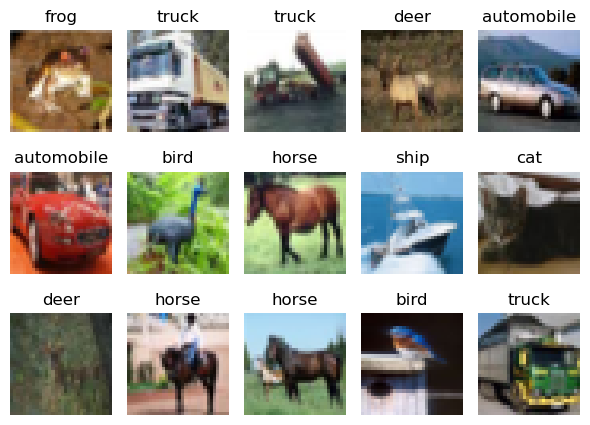

In [7]:
def image_gallery(n_rows=2):
    fig_width = 6
    fig_height = 3 * n_rows / 2
    fig, axs = plt.subplots(n_rows, 5, figsize=(fig_width, fig_height))
    axs = axs.flatten()

    for i in range(n_rows*5):
        img = trainset.data[i]
        axs[i].imshow(img)
        axs[i].set_title(trainset.classes[trainset.targets[i]])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

image_gallery(3)

### Class Distribution

As expected based on the dataset's description, the CIFAR10 dataset includes 50'000 images for each class in the training dataset and is therefore balanced.

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


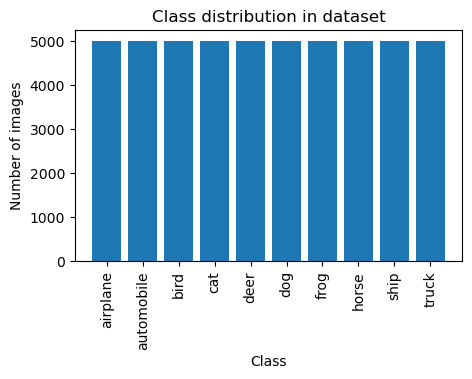

{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}


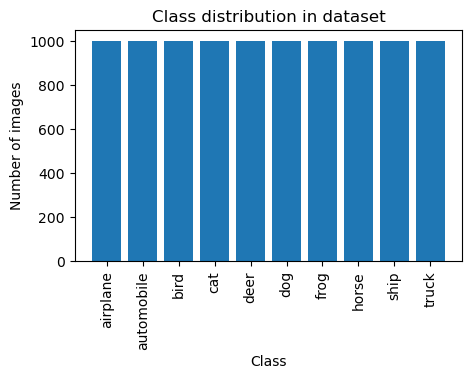

In [8]:
# Check the distribution of the classes in the training set
def show_class_distribution(dataset):
    class_count_dict = {}
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_count_dict:
            class_count_dict[dataset.targets[i]] += 1
        else:
            class_count_dict[dataset.targets[i]] = 1
    for i in range(10):
        if i not in class_count_dict:
            class_count_dict[i] = 0

    print(class_count_dict)

    # plot bar plot with target labels
    plt.bar(range(len(class_count_dict)), list(class_count_dict.values()), align='center')
    plt.xticks(range(len(class_count_dict)), dataset.classes, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in dataset')

    fig = plt.gcf()
    fig.set_size_inches(5, 3)

    plt.show()

show_class_distribution(trainset)
show_class_distribution(testset)

# Schritt 3: Aufbau Modellierung

## Wahl der Evaluierungsmetriken

Ich wähle als Evaluierungsmetrik für meine Deep Learning Modelle auf dem CIFAR-10 Datensatz die **Accuracy**. CIFAR-10 besteht, wie ich im Schritt 2 überprüft habe, aus 10 gleichmässig verteilten Klassen, wobei jede Klasse die gleiche Anzahl von Samples enthält. Damit ist die Accuracy ein angemessene Metrik für die Model Performance - sie misst den Anteil der korrekt klassifizierten Samples im Vergleich zur Gesamtanzahl der Samples. Die Accuracy kann wie folgt definiert werden:

$$
\text{Accuracy} = \frac{\text{Anzahl der korrekt klassifizierten Samples}}{\text{Gesamtanzahl der Samples}}
$$

Der **F1-Score** ist ein weiterer möglicher Kandidat als Evaluierungsmetrik, und misst das harmonische Mittel von Precision und Recall. In Szenarien, in denen der Datensatz unausgeglichen ist oder die Leistung des Modells in Bezug auf bestimmte Klassen von besonderem Interesse ist, kann der F1-Score nützlich sein. Da der CIFAR-10 Datensatz jedoch ausgeglichen ist und ich keine spezielle Anforderung an bestimmte Klassen habe, bietet der F1-Score keinen zusätzlichen Vorteil gegenüber der Accuracy.

## Schätzung des Fehlers

Hat man ein Modell 1 mal trainiert, kann nicht mit Sicherheit gesagt werden, dass die resultierende Accuracy des Modells genau dem entspricht. Trainiert man das Modell ein zweites Mal mit den gleichen Daten, wird eine etwas andere Accuracy resultieren. Dies hängt mit dem Random State (initialisierung der weights, train/test split, ...) zusammen.

Es macht deshalb Sinn, die Variabilität der Model Performance abzuschätzen. Dazu gibt es mehrere Methoden, von denen ich 3 kurz aufzeigen will.

1. **Mehrere Runs**: Um die Variabilität der Model Performance zu schätzen und ein besseres Verständnis dafür zu bekommen, wie das Modell auf unterschiedliche Trainingsbedingungen reagiert, kann man ein Model mehrmals (z. B. 10 Runs) mit unterschiedlichem Random State und/oder verschiedenen Trainings-/Testdaten-Splits trainieren und evaluieren. Durch das Berechnen des Durchschnitts und der Standardabweichung der Accuracy über alle Runs erhält man eine Schätzung der Model Performance über verschiedene Trainingsbedingungen.

2. **Cross-Validation**: Eine weitere Methode zur Bewertung der Model Performance und Abschätzung ihrer Unsicherheit ist k-Fold Cross-Validation. Dabei wird der Datensatz in k gleiche Teile (Folds) aufgeteilt und das Modell k-mal trainiert und validiert. In jedem Durchlauf wird jeweils ein Fold als Validierungsdatensatz und die verbleibenden k-1 Folds als Trainingsdatensatz verwendet. Nach Abschluss der k Iterationen kann man den Durchschnitt und die Standardabweichung der Accuracy über alle Folds berechnen, um Einblick in die Stabilität der Model Performance über verschiedene Trainings-/Validierungsdaten-Splits zu erhalten.

Beide Methoden erfordern zusätzliche Rechenzeit und Ressourcen, insbesondere bei grossen Datensätzen und komplexen Modellen. Eine weitere Möglichkeit, die ich gefunden habe, und die nur einen Run erfordert, ist die Berechnung des Konfidenzintervalls mittels Wilson Score.

3. **Wilson Score Interval**: Um den Fehler in der Schätzung der Accuracy zu berücksichtigen, kann man das Konfidenzintervall berechnen. Dieses gibt an, in welchem Bereich man den wahren Wert der Accuracy mit einer bestimmten Wahrscheinlichkeit (z.B. 95 %) erwarten kann. Es resultiert in einer oberen und unteren Grenze, die man zusätzlich zur Accuracy angeben kann.

## Testen der Trainingsfunktionalität

Ich trainiere ein einfaches Modell auf nur einem Batch.

In [9]:
class SimpleCNN(li.LightningModule):
    """
    A simple convolutional neural network (CNN) for image classification tasks.
    """

    def __init__(self, learning_rate, optimizer):
        super().__init__()

        # Save hyperparameters
        self._learning_rate = learning_rate
        self._optimizer = optimizer

        # Initialize the network layers
        # @ Define the CNN architecture with a single convolutional layer, 3 input channels (RGB) and 16 output channels (filters)
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, padding=1
        )  # from dimension (batch_size, 3, H, W) to (batch_size, 16, H, W)

        # @ Using max-pooling layer to keep only the max value in each 2x2 (size=2) window of the 16 filters, moving 2 pixels at a time (stride=2)
        self.pool = nn.MaxPool2d(
            kernel_size=2, stride=2
        )  # from dimension (batch_size, 16, H, W) to (batch_size, 16, H/2, W/2)

        # @ Fully connected output layer
        self.fc1 = nn.Linear(
            16 * 16 * 16, 10
        )  # takes (batch_size, 16, H/2, W/2) to (batch_size, 10) for our classification task

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        """
        Forward pass through the CNN.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, 32, 32).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 10).
        """
        x = self.pool(
            F.relu(self.conv1(x))
        )  # ReLU activation function to introduce non-linearity
        x = x.view(
            -1, 16 * 16 * 16
        )  # Flatten the output of the convolutional layer (-1 means that the batch size is inferred by PyTorch)
        x = self.fc1(x)  # Fully connected output layer
        return x

    def configure_optimizers(self):
        """
        Set up the optimizer for the CNN.

        Returns:
            torch.optim.Optimizer: The optimizer for this model.
        """
        # Update model parameters using Adam, which combines the ideas of momentum and adaptive learning rates
        if self._optimizer == "SGD":
            return torch.optim.SGD(self.parameters(), lr=self._learning_rate)
        elif self._optimizer == "Adam":
            return torch.optim.Adam(
                self.parameters(), lr=self._learning_rate
            )  # self.parameters() returns current model params; lr is the initial learning rate
        else:
            raise ValueError("Optimizer not supported.")

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            torch.Tensor: The training loss for the current batch.
        """
        inputs, targets = batch
        outputs = self(inputs)  # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Log training accuracy
        self.train_accuracy(preds, targets)
        self.log(
            "train_accuracy",
            self.train_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.

        Args:
            batch (tuple): A tuple containing the input and target tensors.
            batch_idx (int): The index of the current batch.

        Returns:
            None
        """
        inputs, targets = batch
        outputs = self(inputs)  # equivalent to self.forward(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # log validation accuracy
        self.val_accuracy(preds, targets)
        self.log(
            "val_accuracy",
            self.val_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

In [10]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "simple-cnn-singlebatch",
    "method": "grid",
    "metric": {
        "name": "val_accuracy_epoch",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [15]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["SGD", "Adam"]},
    },
}

# Setup Weight & Biases
sweep_id = wandb.sweep(sweep_config, entity="yvokeller", project="deep-learning")

# Create the PyTorch Lightning Trainer
def train_sweep():
    wandb.init()

    model = SimpleCNN(wandb.config.learning_rate, wandb.config.optimizer)

    trainer = li.Trainer(
        max_epochs=wandb.config.epochs,
        limit_train_batches=1,
        limit_val_batches=1,
        logger=WandbLogger(entity="yvokeller", project="deep-learning"),
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[TQDMProgressBar(refresh_rate=10)],  # update every 10 batches
    )

    train_dataloader, val_dataloader = get_dataloaders(batch_size=32)

    trainer.fit(model, train_dataloader, val_dataloader)
    wandb.finish()


# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

Die Evaluation zum ersten Trainingsexperiment ist hier zu finden [Schritt 3](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#schritt-3:-training-setup)

# Schritt 4: Evaluation

## Setup

### Interface Definition

Das `IModel` Interface enthält die Methoden, die für alle Modellarchitekturen gleich bleiben. Damit kann ich es für alle Modelle mit unterschiedlichen Layern etc. wiederverwenden.

In [11]:
class IModel(li.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        # Save hyperparameters
        self.hparams.update(hparams)
        self.__configure_from_hyperparams()

        # Initialize metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # Configure optimizers
        if self.hparams.optimizer == "SGD":
            self.configure_optimizers = self.__configure_optimizers_sgd
        elif self.hparams.optimizer == "Adam":
            self.configure_optimizers = self.__configure_optimizers_adam
        else:
            raise ValueError("Optimizer not supported.")

    def init_weights(self, m):
        if type(m) in {nn.Conv2d, nn.Linear}:
            # Only initialize the weights of the convolutional and linear layers
            if self.hparams.init_method == "xavier_uniform":
                nn.init.xavier_uniform_(m.weight)
            elif self.hparams.init_method == "kaiming_uniform":
                nn.init.kaiming_uniform_(m.weight)
            elif self.hparams.init_method == "xavier_normal":
                nn.init.xavier_normal_(m.weight)
            elif self.hparams.init_method == "kaiming_normal":
                nn.init.kaiming_normal_(m.weight)
            elif self.hparams.init_method is None:
                pass
            else:
                raise ValueError("Invalid initialization method.")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, "train", self.train_accuracy)

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, "val", self.val_accuracy)

    def __configure_optimizers_adam(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

    def __configure_optimizers_sgd(self):
        return torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
            momentum=self.hparams.momentum, # a moving average of our gradients
        )

    def __step(self, batch, batch_idx, stage, metric):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        preds = torch.argmax(outputs, dim=1)

        # Apply L1 regularization if applicable
        if self.hparams.regularization:
            if self.reg_type == "L1":
                l1_lambda = self.reg_value

                l1_reg = torch.tensor(0.0, device=self.device)
                for param in self.parameters():
                    l1_reg += torch.norm(param, 1)

                l1_reg = l1_lambda * l1_reg
                loss = loss + l1_reg

        # Log accuracy
        metric(preds, targets)
        self.log(
            f"{stage}_accuracy",
            metric,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        # Log loss
        self.log(
            f"{stage}_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss
    
    def __configure_from_hyperparams(self):
        # Handle Regularization config
        # Input like: "regularization": {"values": [None, ("l1", 0.1), ("l2", 0.5)]}
        print("Configuring from hyperparameters...")
        if not hasattr(self.hparams, "regularization") or self.hparams.regularization is None:
            print("No regularization defined.")
            self.hparams.regularization = False
            self.hparams.weight_decay = 0
        else:
            # Check if is a tuple with 2 elements
            if isinstance(self.hparams.regularization, tuple):
                if len(self.hparams.regularization) != 2:
                    raise(ValueError("Regularization tuple must have format ('type', 0)."))
                
            print("Regularization: {}".format(self.hparams.regularization))
            self.reg_type = self.hparams.regularization[0]
            self.reg_value = self.hparams.regularization[1]

            # L2 
            if self.reg_type == "L2":
                self.hparams.weight_decay = self.reg_value

        # Fill optional hyperparameters with default values
        self.hparams.weight_decay = self.hparams.get("weight_decay", 0)
        self.hparams.momentum = self.hparams.get("momentum", 0)
        self.hparams.dropout_p = self.hparams.get("dropout_p", 0.5)


### Model Architectures

**Formulas**
- Conv layer: `output_size_1d = (input_size - kernel_size + 2 * padding) / stride + 1`
- Pool layer: `output_size_1d = math.floor((input_size - pool_size) / stride + 1)`
- Fc layer input: `input_size = output_size_last_pool * output_size_last_pool * num_filters_last_pool`

#### Einfaches Modell

In [12]:
class SmallCNN_k3(IModel):
    """
    Small CNN with kernel size 3
    Spatial dimensions of filters are reduced one by MaxPool layer, then 2 fully connected layers
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 3 + 2 * 0) / 1 + 1 = 30
        self.conv1 = nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=0, dilation=1
        )

        # @ Conv2
        # (30 - 3 + 2 * 0) / 1 + 1 = 28
        self.conv2 = nn.Conv2d(
            16, 16, kernel_size=3, stride=1, padding=0, dilation=1
        )

        # @ Pool
        # math.floor((28 - 2) / 2 + 1) = 14
        self.pool = nn.MaxPool2d(
            kernel_size=2, stride=2
        )

        # @ Fully connected layers
        # input_size = in_channels * output_size_last_pool * output_size_last_pool
        size_after_pooling = 14
        fc_input_size = 16 * size_after_pooling * size_after_pooling # 3136

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Mittleres Modell

##### Base Architectures

In [13]:
class MediumCNN_k3(IModel):
    """
    Medium CNN with kernel size 3
    Spatial dimensions of filters are reduced twice by MaxPool layers
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 3 + 2 * 1) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv2
        # (32 - 3 + 2 * 1) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1
        )
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 3 + 2 * 1) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv4
        # (16 - 3 + 2 * 1) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 8
        fc_input_size = 256 * size_after_pooling * size_after_pooling

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MediumCNN_k3_stride2_GAP(IModel):
    """
    Medium CNN with kernel size 3
    Spatial dimensions of filters are reduced twice by stride 2 in 2nd and 4th conv layers with padding of 1 to keep image edge information
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 3 + 2 * 0) / 1 + 1 = 30
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=0, dilation=1
        )

        # @ Conv2
        # (30 - 3 + 2 * 1) / 2 + 1 = 15.5 -> 15
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=2, padding=1, dilation=1
        )

        # @ Conv3
        # (15 - 3 + 2 * 0 / 1 + 1) = 13
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=3, stride=1, padding=0, dilation=1
        )

        # @ Conv4
        # (13 - 3 + 2 * 1 / 2 + 1) = 12
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=3, stride=2, padding=1, dilation=1
        )

        # @ Pool2
        # math.floor((12 - 2) / 2 + 1) = 6
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv5
        # (6 - 3 + 2 * 0 / 1 + 1) = 4
        self.conv5 = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=0, dilation=1
        )

        # @ GlobalAvgPool
        # from 4x4 to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 1
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 256

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)) # stride 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x)) # stride 2
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MediumCNN_k5(IModel):
    """
    Medium CNN with kernel size 5
    Spatial dimensions of filters are reduced twice by MaxPool layers to 8x8
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv2
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, stride=1, padding=2, dilation=1
        )
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv4
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 8
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 16384

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MediumCNN_k5_GAP(IModel):
    """
    Medium CNN with kernel size 5
    Spatial dimensions of filters are reduced twice by MaxPool layers to 8x8, then finally to 1x1 by Global Average Pooling
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv2
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, stride=1, padding=2, dilation=1
        )
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv4
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ GlobalAvgPool
        # from 8x8 to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 1
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 256

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### Extended Architectures for Dropout / Batch Normalization

In [14]:
class MediumCNN_k5_dropout_fc(IModel):
    """
    Medium CNN with kernel size 5
    Spatial dimensions of filters are reduced twice by MaxPool layers to 8x8
    Utilizes dropout for fully connected layers
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv2
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, stride=1, padding=2, dilation=1
        )
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Conv4
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=5, stride=1, padding=2, dilation=1
        )

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 8
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 16384

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.dropout_fc1 = nn.Dropout(p=self.hparams.dropout_p)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x
    
class MediumCNN_k5_dropout_all(IModel):
    """
    Medium CNN with kernel size 5
    Spatial dimensions of filters are reduced twice by MaxPool layers to 8x8
    Utilizes dropout for CNN layers (spatial dropout) and fully connected layers
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.spatial_dropout1 = nn.Dropout2d(p=self.hparams.dropout_p)

        # @ Conv2
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.spatial_dropout2 = nn.Dropout2d(p=self.hparams.dropout_p)
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.spatial_dropout3 = nn.Dropout2d(p=self.hparams.dropout_p)

        # @ Conv4
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.spatial_dropout4 = nn.Dropout2d(p=self.hparams.dropout_p)

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 8
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 16384

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.dropout_fc1 = nn.Dropout(p=self.hparams.dropout_p)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.spatial_dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.spatial_dropout2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.spatial_dropout3(x)
        x = F.relu(self.conv4(x))
        x = self.spatial_dropout4(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x
    
class MediumCNN_k5_batchnorm(IModel):
    """
    Medium CNN with kernel size 5
    Spatial dimensions of filters are reduced twice by MaxPool layers to 8x8
    Utilizes batch normalization for CNN layers and fully connected layers
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.batchnorm1 = nn.BatchNorm2d(32)

        # @ Conv2
        # (32 - 5 + 2 * 2) / 1 + 1 = 32
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.batchnorm3 = nn.BatchNorm2d(128)

        # @ Conv4
        # (16 - 5 + 2 * 2) / 1 + 1 = 16
        self.conv4 = nn.Conv2d(
            128, 256, kernel_size=5, stride=1, padding=2, dilation=1
        )
        self.batchnorm4 = nn.BatchNorm2d(256)

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 8
        fc_input_size = 256 * size_after_pooling * size_after_pooling # 16384

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.batchnorm_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.batchnorm_fc1(x)
        x = self.fc2(x)
        return x

#### Komplexes Modell

In [15]:
class ComplexCNN_k3(IModel):
    """
    Complex CNN with kernel size 3
    Inspired by VGG16 architecture, but with 3 less convolutional layers and one additional fully connected layer
    """
    def __init__(
        self,
        hparams
    ):
        super().__init__(hparams)

        # Initialize the network layers
        # @ Conv1
        # (32 - 3 + 2 * 1 / 1 + 1) = 32
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv2
        # (32 - 3 + 2 * 1 / 1 + 1) = 32
        self.conv2 = nn.Conv2d(
            64, 64, kernel_size=3, stride=1, padding=1, dilation=1
        )
        
        # @ Pool1
        # math.floor((32 - 2) / 2 + 1) = 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv3
        # (16 - 3 + 2 * 1 / 1 + 1) = 16
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv4
        # (16 - 3 + 2 * 1 / 1 + 1) = 16
        self.conv4 = nn.Conv2d(
            128, 128, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Pool2
        # math.floor((16 - 2) / 2 + 1) = 8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv5
        # (8 - 3 + 2 * 1 / 1 + 1) = 8
        self.conv5 = nn.Conv2d(
            128, 256, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv6
        # (8 - 3 + 2 * 1 / 1 + 1) = 8
        self.conv6 = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv7
        # (8 - 3 + 2 * 1 / 1 + 1) = 8
        self.conv7 = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Pool3
        # math.floor((8 - 2) / 2 + 1) = 4
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # @ Conv8
        # (4 - 3 + 2 * 1 / 1 + 1) = 4
        self.conv8 = nn.Conv2d(
            256, 512, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv9
        # (4 - 3 + 2 * 1 / 1 + 1) = 4
        self.conv9 = nn.Conv2d(
            512, 512, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Conv10
        # (4 - 3 + 2 * 1 / 1 + 1) = 4
        self.conv10 = nn.Conv2d(
            512, 512, kernel_size=3, stride=1, padding=1, dilation=1
        )

        # @ Pool4
        # math.floor((4 - 2) / 2 + 1) = 2
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully connected layers based on the input hyperparameters
        size_after_pooling = 2
        fc_input_size = 512 * size_after_pooling * size_after_pooling # 2048

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool3(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Runner

Das `TrainingCallback` sendet mir ein E-Mail über WandB, wenn ein Modell fertig trainiert ist.

Die `sweep_runner` Funktion kann ich mit einer definierten Sweep Config aufrufen, und das entsprechende Modell mit en angegebenen Parametern trainieren.

In [16]:
class TrainingCallback(Callback):
    def __init__(self, config): 
        super().__init__()

        self.config = config

    def on_fit_start(self, trainer, pl_module):
        print("Training is starting")

    def on_fit_end(self, trainer, pl_module):
        wandb.alert(
            title="Training Complete", 
            text=f"Model {self.config['model']} has finished training with a final accuracy of {trainer.callback_metrics['val_accuracy']:.2f}\n\n{str(self.config)}"
        )
        print("Training is ending")

In [17]:
def sweep_runner(sweep_config, group_name='', shuffle_data=False):
    """
    Run a sweep with the given sweep configuration and group name.
    """
    # Setup Weight & Biases
    sweep_id = wandb.sweep(
        sweep_config, entity='yvokeller', project='deep-learning'
    )

    if group_name:
        group_name = group_name if group_name else ''
        print(f"Group name: {group_name} - Make sure to update wandb.init()")
    else:
        group_name = None

    # Create the PyTorch Lightning Trainer
    def train_sweep():
        with wandb.init() as run: # optionally pass group=group_name here
            # Overwrite the random run names chosen by wandb
            name_str = (
                f"{run.config.model}_"
                f"lr_{run.config.learning_rate}_"
                f"bs_{run.config.batch_size}"
            )
            run.name = name_str

            # Initialize the model
            if run.config.model == 'SmallCNN_k3':
                model = SmallCNN_k3(run.config)
            elif run.config.model == 'MediumCNN_k3':
                model = MediumCNN_k3(run.config)
            elif run.config.model == 'MediumCNN_k3_stride2_GAP':
                model = MediumCNN_k3_stride2_GAP(run.config)
            elif run.config.model == 'MediumCNN_k5':
                model = MediumCNN_k5(run.config)
            elif run.config.model == 'MediumCNN_k5_dropout_fc':
                model = MediumCNN_k5_dropout_fc(run.config)
            elif run.config.model == 'MediumCNN_k5_dropout_all':
                model = MediumCNN_k5_dropout_all(run.config)
            elif run.config.model == 'MediumCNN_k5_batchnorm':
                model = MediumCNN_k5_batchnorm(run.config)
            elif run.config.model == 'MediumCNN_k5_GAP':
                model = MediumCNN_k5_GAP(run.config)
            elif run.config.model == 'ComplexCNN_k3':
                model = ComplexCNN_k3(run.config)
            else:
                raise ValueError(f"Model {run.config.model} not found.")

            # Initialize weights
            model.apply(
                model.init_weights
            ) # traverse through the layers and initialize the weights

            trainer = li.Trainer(
                max_epochs=wandb.config.epochs,
                logger=WandbLogger(entity='yvokeller', project='deep-learning'),
                log_every_n_steps=1,
                enable_progress_bar=True,
                callbacks=[TQDMProgressBar(refresh_rate=10), TrainingCallback(run.config)] # update every 10 batches
            )

            train_dataloader, val_dataloader = get_dataloaders(batch_size=wandb.config.batch_size, val_nobatch=True, shuffle=shuffle_data)

            trainer.fit(model, train_dataloader, val_dataloader)

    # Run the sweep
    wandb.agent(sweep_id, function=train_sweep)

## Experimente

### Vorgehen
**Schritt 1: Modellarchitekturen entwickeln**

Ich entwickle mehrere Modellarchitekturen mit zunehmender Komplexität. Dabei variiere ich neben der Anzahl CNN Layers auch die Kernel Size, die Anzahl Filter, den Stride und das Padding. Das einfachste Modell soll als Baseline Modell dienen.

| Model                | Params   |
|----------------------|----------|
| SmallCNN_k3          | 1.6M     |
| MediumCNN_k3         | 8.8M     |
| MediumCNN_k3_stride2_GAP | 1M |
| MediumCNN_k5         | 9.5M     |
| MediumCNN_k5_GAP     | 1.1M     |
| ComplexCNN_k3        | 10.3M    |

**Schritt 2: Geeignetes Modell finden**

In Schritt 2 suche ich das geeignete Modell für die Experimente in Schritt 3.

1. Ich trainiere die Modelle aus Schritt 1 mittels einem W&B Sweep und varriere dabei die Learning Rate: 0.1 0.01 0.001 0.0001
2. Um den Effekt der Batch Size zu sehen, teste ich dann beim besten Modell 3 verschiedene Batch Sizes: 32, 64, 128

Anschliessend evaluiere ich die Resultate und wähle die am besten geeignete Modell- und Hyperparameterkombination für Schritt 3 aus. Dabei stelle ich die Model Performance und die benötigte Trainingszeit gegenüber. Dieses Modell verwende ich in Schritt 3 immer als Grundlage.

**Schritt 3: Experimentieren mit Hyperparametern**

In Schritt 3 trainiere ich das gewählte Modell, übernehme die besten Hyperparameter (Batch Size, Learning Rate) aus Schritt 2 und probiere zusätzlich Regularisierung, Weight Initialization, Batchnorm, den Adam Optimizer etc. aus. Mein Ziel in diesem Schritt ist es nicht, das beste Modell zu finden, sondern Erkenntnisse darüber zu gewinnen, wie der Trainingsprozess und die Model Performance sich durch das anpassen dieser Parameter verändern und gegenseitig beeinflussen.

Ich trainiere das Modell mit jeweils einem W&B Sweep über folgende Hyperparameter, und übernehme jeweils aus dem vorherigen Sweep die Hyperparameter-Kombination, die das beste Resultat erzielt hat:

1. Weight Initialization: xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal
2. Regularisierung: L1, L2, Dropout
3. Zusätzlich ausprobieren:
    1. Pfad Batchnorm (ohne Regularisierung) → Batchnorm
    2. Pfad Optimizer (mit & ohne Regularisierung) → Adam anstatt SGD

**Schritt 4**

Ich wähle das beste Modell über alle Experimente, und berechne mittels Cross-Validation den Schätzfehler für die Evaluierungsmetrik Accuracy.

#### WandB Report für Evaluation

Die Evaluation aller Experimente ist in meinem WandB Report zu finden. Die Nummerierung der Experimente im WandB Report entspricht der Nummerierung im Jupyter Notebook. Zusätzlich steht bei jedem Experiment im Jupyter Notebook ein Direktlink zum entsprechenden Kapitel im WandB Report zur Verfügung.

<iframe width="100%" height="500" src="https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1"></iframe>

### Experiment 1.1: Learning Rate

Ich vergleiche der Leistung meiner verschiedenen Modellarchitekturen bei unterschiedlichen Learning Rates.

In [18]:
sweep_config = {
    "name": "experiment-1.1",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "SmallCNN_k3",
                "MediumCNN_k3",
                "MediumCNN_k3_stride2_GAP",
                "MediumCNN_k5",
                "MediumCNN_k5_GAP",
                "ComplexCNN_k3",
            ]
        },
        "epochs": {"values": [40]},
        "learning_rate": {"values": [1e-1, 1e-2, 1e-3, 1e-4]},
        "batch_size": {"values": [64]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None]},
    },
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Learning Rate und Modellarchitekturen](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-1-1)

### Experiment 1.2 extra

Die Ergebisse in 1.1 waren nicht eindeutig, unter anderem weil das Training bei einigen Modellen nach 40 Epochen mit einer Learning Rate von 0.001 noch nicht ganz abgeschlossen zu sein scheint, jedoch da auch die beste Performance auf dem Validation Set erreicht wurde. Deshalb trainiere ich nun diese drei besten Modelle nochmal mit zwei etwas höheren Learning Rates, um zu sehen, ob sich die Performance noch verbessert.

In [19]:
sweep_config = {
    "name": "experiment-1.1-extra",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k3",
                "MediumCNN_k5",
                "MediumCNN_k5_GAP",
            ]
        },
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.0025, 0.005]},
        "batch_size": {"values": [64]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None]},
    },
}

# sweep_runner(sweep_config)

### Experiment 1.2: Batch Size

Ich habe das Modell **MediumCNN_k5** mit Lernrate 0.001 gewählt. Es hat im Experiment 1.1 die besten Resultate erzielt. Ich trainiere dieses nun mit verschiedenen Batch Sizes und vergleiche die Resultate, um die Auswirkungen der Batch Size besser zu verstehen.

In [20]:
sweep_config = {
    "name": "experiment-1.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5",
            ]
        },
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [16, 32, 64, 128]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None]},
    },
}

# sweep_runner(sweep_config)

In [21]:
sweep_config = {
    "name": "experiment-1.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5",
            ]
        },
        "epochs": {"values": [100]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [128]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None]},
    },
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Batch Size](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-1.2:-batch-size)

### Experiment 2.1: Weight Initialization

Ich trainiere das beste Modell aus Experiment 1.2 mit verschiedenen Weight Initializations und vergleiche die Resultate, um den Effekt zu evaluieren und verstehen.

In [22]:
sweep_config = {
    "name": "experiment-2.1",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5",
            ]
        },
        "experiment": {"values": ["ex-2.1-w_init"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": [None, "xavier_normal", "xavier_uniform", "kaiming_normal", "kaiming_uniform"]},
    },
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Report - Weight Initialization](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-2.1:-weight-initialisation)

### Experiment 2.2: Regularisierung

Ich trainiere das beste Modell aus Experiment 2.1 mit verschiedenen Regularisierungs-Methoden und vergleiche die Resultate, um den Effekt zu evaluieren und zu verstehen.

In [23]:
# L1 and L2 regularization
sweep_config = {
    "name": "experiment-2.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5",
            ]
        },
        "experiment": {"values": ["ex-2.2-reg"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": ["xavier_normal"]},
        "regularization": {"values": [None, ("L1", 0.001), ("L2", 0.1)]},
    },
}

# sweep_runner(sweep_config)

In [24]:
# Dropout
sweep_config = {
    "name": "experiment-2.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5_dropout_fc",
                "MediumCNN_k5_dropout_all",
            ]
        },
        "experiment": {"values": ["ex-2.2-reg"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": ["xavier_normal"]},
        "dropout_p": {"values": [0.5]}
    }
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Regularization](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-2.2:-regularization)

### Experiment 2.3.1: Batch Norm

Ich trainiere das beste Modell aus Experiment 2.1 (keine Regularisierung) mit Batchnorm und vergleiche die Resultate, um den Effekt zu evaluieren und zu verstehen.

In [25]:
# Batchnorm
sweep_config = {
    "name": "experiment-2.3.1",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5_batchnorm"
            ]
        },
        "experiment": {"values": ["ex-2.3.1-batchnorm"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["SGD"]},
        "init_method": {"values": ["xavier_normal"]}
    }
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Batch Norm](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-2.3.1:-batch-norm)

### Experiment 2.3.2: Adam

Ich trainiere das beste Modell aus Experiment 2.1 (ohne Regularisierung) und 2.2 (mit Regularisierung) mit dem Adam Optimizer und vergleiche die Resultate, um den Effekt zu evaluieren und zu verstehen.

In [26]:
# Adam on best model from experiment 2.1 (without regularization)
sweep_config = {
    "name": "experiment-2.3.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5",
            ]
        },
        "experiment": {"values": ["ex-2.3.2-adam"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001, 0.0001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["Adam"]},
        "init_method": {"values": ["xavier_normal"]},
    },
}

# sweep_runner(sweep_config)

In [27]:
# Adam on best model from experiment 2.2 (with dropout regularization)
sweep_config = {
    "name": "experiment-2.3.2",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5_dropout_fc"
            ]
        },
        "experiment": {"values": ["ex-2.3.2-adam"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.001, 0.0001]},
        "batch_size": {"values": [16]},
        "optimizer": {"values": ["Adam"]},
        "init_method": {"values": ["xavier_normal"]},
        "dropout_p": {"values": [0.5]}
    }
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Adam](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#experiment-2.3.2:-adam)

### Schätzfehler Accuracy für Bestes Modell

Ich berechne nun für das Modell das die besten Resultate erzielt hat, mittels mehrerer Runs den Schätzfehler für die Evaluierungsmetrik Accuracy.

In [ ]:
# Schätzfehler für die Evaluierungsmetrik Accuracy mit 5 Runs
sweep_config = {
    "name": "experiment-best-model",
    "method": "grid",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5_dropout_fc",
            ]
        },
        "experiment": {"values": ["ex-best-model"]},
        "epochs": {"values": [40]},
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16, 16, 16, 16, 16]},
        "optimizer": {"values": ["Adam"]},
        "init_method": {"values": ["xavier_normal"]}
    },
}

# sweep_runner(sweep_config, shuffle_data=True)

Die Evaluation zu diesem Experiment hier zu finden: [Schätzfehler Accuracy für bestes Modell](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#schätzfehler-accuracy-für-bestes-modelle)

### Fazit

Zum Schluss möchte ich die besten Modelle aus allen Experimenten betrachten und gegenüberstellen.

Das Fazit ist hier zu finden: [Fazit](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#fazit)

### Zusätzliche Verbesserung der Performance

Ich versuche mit einem letzten W&B Bayes Sweep die Performance des besten Modells nochmals zu verbessern.

In [ ]:
# Bayes Search
sweep_config = {
    "name": "experiment-bayes-search",
    "method": "bayes",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "model": {
            "values": [
                "MediumCNN_k5_dropout_fc",
            ]
        },
        "experiment": {"values": ["ex-bayes-search"]},
        "epochs": {"min": 10, "max": 40},
        "learning_rate": {"distribution": "log_uniform_values", "min": 0.00001, "max": 0.01},
        "batch_size": {"values": [16, 64, 128]},
        "optimizer": {"values": ["Adam"]},
        "init_method": {"values": ["xavier_normal"]}
    },
}

# sweep_runner(sweep_config)

Die Evaluation zu diesem Experiment hier zu finden: [Zusätzliche Verbesserung der Performance](https://wandb.ai/yvokeller/deep-learning/reports/Deep-Learning--Vmlldzo0MDM1MzE1#bonus:-zusätzliche-verbesserung-der-performance)